## Import Libraries

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_absolute_error
from datetime import datetime
from datetime import date
import yfinance as yf
import matplotlib.pyplot as plt
import math


## Data Collection/Processing

[*********************100%***********************]  1 of 1 completed


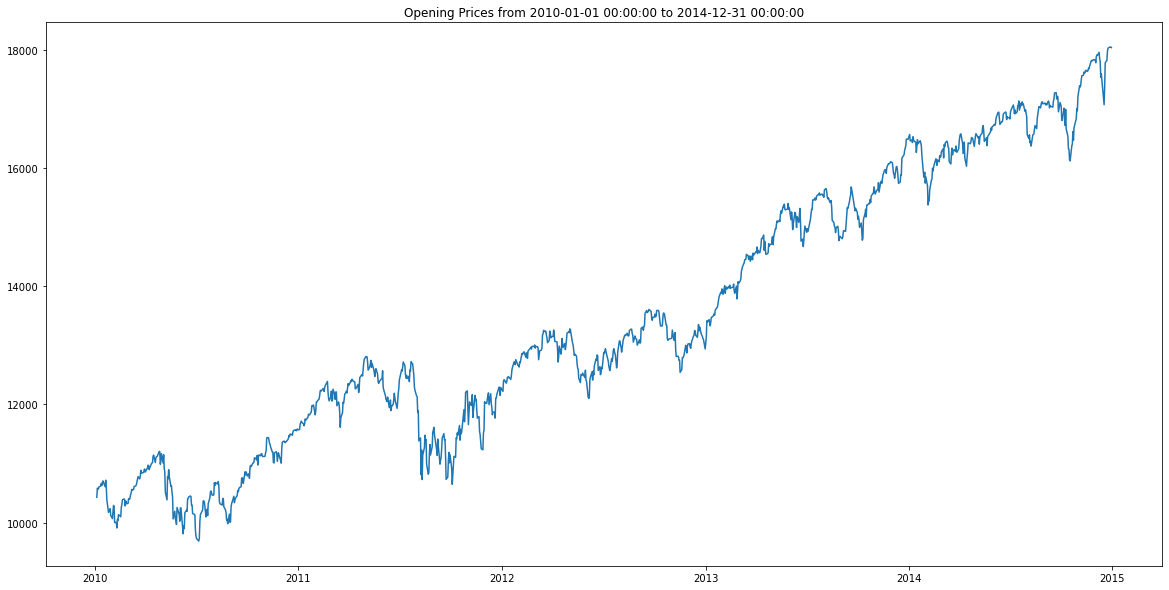

In [3]:
# Select date range
start_date = datetime(2010, 1, 1)
#end_date = date.today()
end_date = datetime(2014, 12, 31)
  
# Download ticker data from Yahoo Finance
ticker = 'DJIA'
df = yf.download(ticker, start = start_date,
                   end = end_date)
  
# Visualization
plt.figure(figsize = (20,10))
plt.title('Opening Prices from {} to {}'.format(start_date,
                                                end_date))
plt.plot(df['Open'])
plt.show()

In [4]:
# Preview data
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,10430.690430,10641.620117,10430.690430,10583.959961,10583.959961,3991400000
2010-01-05,10584.559570,10647.139648,10468.860352,10572.019531,10572.019531,2491020000
2010-01-06,10564.719727,10655.219727,10488.280273,10573.679688,10573.679688,4972660000
2010-01-07,10571.110352,10655.599609,10471.730469,10606.860352,10606.860352,5270680000
2010-01-08,10606.400391,10653.110352,10509.740234,10618.190430,10618.190430,4389590000


In [5]:
# Set Target Variable
target = 'Open'
df_target = pd.DataFrame(df[target], index=df.index)
df_target.head()

,Open
Date,
2010-01-04,10430.690430
2010-01-05,10584.559570
2010-01-06,10564.719727
2010-01-07,10571.110352
2010-01-08,10606.400391


In [6]:
# Scale Target variable
target_scaler = MinMaxScaler()
df_target_scaled = pd.DataFrame(target_scaler.fit_transform(df_target), columns=["Target"], index=df_target.index)
df_target_scaled.head()

,Target
Date,
2010-01-04,0.088722
2010-01-05,0.107133
2010-01-06,0.104759
2010-01-07,0.105524
2010-01-08,0.109746


In [7]:
#Selecting the Features: for this example we will use all the columns
features = df.columns
features

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [8]:
#Scale features
features_scaler = MinMaxScaler()
df_scaled = features_scaler.fit_transform(df[features])
df_scaled = pd.DataFrame(columns=features, data=df_scaled, index=df.index)
df_scaled.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,0.088722,0.100928,0.099371,0.107261,0.107261,0.309232
2010-01-05,0.107133,0.101588,0.103916,0.105834,0.105834,0.152825
2010-01-06,0.104759,0.102555,0.106228,0.106033,0.106033,0.411523
2010-01-07,0.105524,0.102601,0.104257,0.109998,0.109998,0.442590
2010-01-08,0.109746,0.102303,0.108783,0.111352,0.111352,0.350741


In [9]:
## Generate lags to produce for feature engineering
df_features = pd.DataFrame(index = df_scaled.index)

# Daily lags
lags = [l for l in range(1, 8)]

# Weekly lags
weeks = 5
lag_weeks = [l*7 for l in range(2,weeks+1)]
lags.extend(lag_weeks)

# Add lags to feature set
for lag in lags:
    df_shift = df_scaled[features].shift(lag)
    df_shift.columns = [col+'_'+str(lag) for col in df_shift.columns]
    df_features = df_features.merge(df_shift, left_index=True, right_index=True)

df_features = df_features.dropna(how='any')
df_features.head()

,Open_1,High_1,Low_1,Close_1,Adj Close_1,Volume_1,Open_2,High_2,Low_2,Close_2,...,Low_28,Close_28,Adj Close_28,Volume_28,Open_35,High_35,Low_35,Close_35,Adj Close_35,Volume_35
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-24,0.083035,0.075624,0.076590,0.071222,0.071222,0.364445,0.085340,0.080218,0.087746,0.083289,...,0.115846,0.118831,0.118831,0.327887,0.088722,0.100928,0.099371,0.107261,0.107261,0.309232
2010-02-25,0.071170,0.074042,0.080432,0.082187,0.082187,0.327679,0.083035,0.075624,0.076590,0.071222,...,0.121793,0.122390,0.122390,0.301288,0.107133,0.101588,0.103916,0.105834,0.105834,0.152825
2010-02-26,0.081053,0.068018,0.066638,0.075837,0.075837,0.364453,0.071170,0.074042,0.080432,0.082187,...,0.111086,0.110332,0.110332,0.389222,0.104759,0.102555,0.106228,0.106033,0.106033,0.411523
2010-03-01,0.075646,0.070966,0.077912,0.076343,0.076343,0.304414,0.081053,0.068018,0.066638,0.075837,...,0.114227,0.124169,0.124169,0.385688,0.105524,0.102601,0.104257,0.109998,0.109998,0.442590
2010-03-02,0.076207,0.077352,0.086199,0.085728,0.085728,0.294245,0.075646,0.070966,0.077912,0.076343,...,0.106713,0.109555,0.109555,0.394625,0.109746,0.102303,0.108783,0.111352,0.111352,0.350741


## Train/Test Split

In [10]:
## Train/Test Split
split_date = '2014-01-01'
X_train = np.array(df_features.loc[:split_date])
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = np.array(df_features.loc[split_date:])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_train = np.array(df_target_scaled.loc[df_features.index[0]:split_date]).reshape(-1)
y_test = np.array(df_target_scaled.loc[split_date:]).reshape(-1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((971, 1, 66), (251, 1, 66), (971,), (251,))

In [11]:
## Define train/test indices
train_index = df_features.loc[:split_date].index
test_index = df_features.loc[split_date:].index

## Build/Train LSTM

In [13]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, X_train.shape[2]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
#plot_model(lstm, show_shapes=True, show_layer_names=True)

In [14]:
#Model Training
history=lstm.fit(X_train, y_train, epochs=1000, batch_size=100, verbose=1, shuffle=False)
history

Epoch 1/1000
10/10 [==============================] - 1s 2ms/step - loss: 0.0626
Epoch 2/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0035
Epoch 3/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0075
Epoch 4/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0029
Epoch 5/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0026
Epoch 6/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0013
Epoch 7/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 8/1000
10/10 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 9/1000
10/10 [==============================] - 0s 1ms/step - loss: 9.9265e-04
Epoch 10/1000
10/10 [==============================] - 0s 1ms/step - loss: 9.4519e-04
Epoch 11/1000
10/10 [==============================] - 0s 1ms/step - loss: 8.6113e-04
Epoch 12/1000
10/10 [==============================] - 0s 1ms/step - loss: 8.0537e-04
Epoch 13/

10/10 [==============================] - 0s 1ms/step - loss: 3.5797e-04
Epoch 98/1000
10/10 [==============================] - 0s 1ms/step - loss: 3.5673e-04
Epoch 99/1000
10/10 [==============================] - 0s 1ms/step - loss: 3.7112e-04
Epoch 100/1000
10/10 [==============================] - 0s 1ms/step - loss: 3.7505e-04
Epoch 101/1000
10/10 [==============================] - 0s 1ms/step - loss: 3.8272e-04
Epoch 102/1000
10/10 [==============================] - 0s 1ms/step - loss: 4.0242e-04
Epoch 103/1000
10/10 [==============================] - 0s 1ms/step - loss: 4.0632e-04
Epoch 104/1000
10/10 [==============================] - 0s 1ms/step - loss: 4.3619e-04
Epoch 105/1000
10/10 [==============================] - 0s 1ms/step - loss: 4.3698e-04
Epoch 106/1000
10/10 [==============================] - 0s 1ms/step - loss: 4.8208e-04
Epoch 107/1000
10/10 [==============================] - 0s 1ms/step - loss: 4.7737e-04
Epoch 108/1000
10/10 [==============================] - 0s 1

10/10 [==============================] - 0s 1ms/step - loss: 2.0582e-04
Epoch 193/1000
10/10 [==============================] - 0s 1ms/step - loss: 2.0955e-04
Epoch 194/1000
10/10 [==============================] - 0s 1ms/step - loss: 2.0821e-04
Epoch 195/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.9366e-04
Epoch 196/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.8177e-04
Epoch 197/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.7641e-04
Epoch 198/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.6892e-04
Epoch 199/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.4799e-04
Epoch 200/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.3881e-04
Epoch 201/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.3326e-04
Epoch 202/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.3341e-04
Epoch 203/1000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 1ms/step - loss: 5.0594e-04
Epoch 287/1000
10/10 [==============================] - 0s 1ms/step - loss: 5.1132e-04
Epoch 288/1000
10/10 [==============================] - 0s 1ms/step - loss: 4.7105e-04
Epoch 289/1000
10/10 [==============================] - 0s 1ms/step - loss: 4.7028e-04
Epoch 290/1000
10/10 [==============================] - 0s 1ms/step - loss: 4.3149e-04
Epoch 291/1000
10/10 [==============================] - 0s 1ms/step - loss: 4.2674e-04
Epoch 292/1000
10/10 [==============================] - 0s 1ms/step - loss: 3.9310e-04
Epoch 293/1000
10/10 [==============================] - 0s 1ms/step - loss: 3.8795e-04
Epoch 294/1000
10/10 [==============================] - 0s 1ms/step - loss: 3.5911e-04
Epoch 295/1000
10/10 [==============================] - 0s 1ms/step - loss: 3.5438e-04
Epoch 296/1000
10/10 [==============================] - 0s 1ms/step - loss: 3.3240e-04
Epoch 297/1000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 1ms/step - loss: 1.4761e-04
Epoch 381/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.3690e-04
Epoch 382/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.2982e-04
Epoch 383/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.1913e-04
Epoch 384/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.1098e-04
Epoch 385/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.0268e-04
Epoch 386/1000
10/10 [==============================] - 0s 1ms/step - loss: 9.8573e-05
Epoch 387/1000
10/10 [==============================] - 0s 1ms/step - loss: 9.5413e-05
Epoch 388/1000
10/10 [==============================] - 0s 1ms/step - loss: 9.4880e-05
Epoch 389/1000
10/10 [==============================] - 0s 1ms/step - loss: 9.4087e-05
Epoch 390/1000
10/10 [==============================] - 0s 1ms/step - loss: 9.2690e-05
Epoch 391/1000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 1ms/step - loss: 1.3077e-04
Epoch 475/1000
10/10 [==============================] - 0s 1ms/step - loss: 9.8509e-05
Epoch 476/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.1014e-04
Epoch 477/1000
10/10 [==============================] - 0s 1ms/step - loss: 8.6412e-05
Epoch 478/1000
10/10 [==============================] - 0s 1ms/step - loss: 8.6558e-05
Epoch 479/1000
10/10 [==============================] - 0s 1ms/step - loss: 8.5477e-05
Epoch 480/1000
10/10 [==============================] - 0s 1ms/step - loss: 8.0051e-05
Epoch 481/1000
10/10 [==============================] - 0s 1ms/step - loss: 9.1929e-05
Epoch 482/1000
10/10 [==============================] - 0s 1ms/step - loss: 7.8075e-05
Epoch 483/1000
10/10 [==============================] - 0s 1ms/step - loss: 9.0308e-05
Epoch 484/1000
10/10 [==============================] - 0s 1ms/step - loss: 9.9265e-05
Epoch 485/1000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 1ms/step - loss: 2.3520e-04
Epoch 569/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.3876e-04
Epoch 570/1000
10/10 [==============================] - 0s 1ms/step - loss: 2.6737e-04
Epoch 571/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.4300e-04
Epoch 572/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.1519e-04
Epoch 573/1000
10/10 [==============================] - 0s 2ms/step - loss: 1.7011e-04
Epoch 574/1000
10/10 [==============================] - 0s 1ms/step - loss: 8.5233e-05
Epoch 575/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.2119e-04
Epoch 576/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.2118e-04
Epoch 577/1000
10/10 [==============================] - 0s 1ms/step - loss: 9.7929e-05
Epoch 578/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.5204e-04
Epoch 579/1000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 1ms/step - loss: 1.4487e-04
Epoch 663/1000
10/10 [==============================] - 0s 1ms/step - loss: 2.3757e-04
Epoch 664/1000
10/10 [==============================] - 0s 1ms/step - loss: 9.2969e-05
Epoch 665/1000
10/10 [==============================] - 0s 1ms/step - loss: 2.1487e-04
Epoch 666/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.5046e-04
Epoch 667/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.6657e-04
Epoch 668/1000
10/10 [==============================] - 0s 1ms/step - loss: 2.1570e-04
Epoch 669/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.1980e-04
Epoch 670/1000
10/10 [==============================] - 0s 1ms/step - loss: 2.5981e-04
Epoch 671/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.3997e-04
Epoch 672/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.3328e-04
Epoch 673/1000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 1ms/step - loss: 1.6417e-04
Epoch 757/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.3502e-04
Epoch 758/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.1928e-04
Epoch 759/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.7683e-04
Epoch 760/1000
10/10 [==============================] - 0s 1ms/step - loss: 9.9270e-05
Epoch 761/1000
10/10 [==============================] - 0s 1ms/step - loss: 2.1573e-04
Epoch 762/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.1687e-04
Epoch 763/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.3396e-04
Epoch 764/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.8552e-04
Epoch 765/1000
10/10 [==============================] - 0s 1ms/step - loss: 7.4955e-05
Epoch 766/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.6036e-04
Epoch 767/1000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 1ms/step - loss: 6.9698e-05
Epoch 851/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.5452e-04
Epoch 852/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.0161e-04
Epoch 853/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.3687e-04
Epoch 854/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.4394e-04
Epoch 855/1000
10/10 [==============================] - 0s 1ms/step - loss: 9.8492e-05
Epoch 856/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.9991e-04
Epoch 857/1000
10/10 [==============================] - 0s 1ms/step - loss: 7.9725e-05
Epoch 858/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.4259e-04
Epoch 859/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.3334e-04
Epoch 860/1000
10/10 [==============================] - 0s 1ms/step - loss: 9.2884e-05
Epoch 861/1000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 1ms/step - loss: 9.8488e-05
Epoch 945/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.7994e-04
Epoch 946/1000
10/10 [==============================] - 0s 1ms/step - loss: 6.6235e-05
Epoch 947/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.3998e-04
Epoch 948/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.0460e-04
Epoch 949/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.0558e-04
Epoch 950/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.3477e-04
Epoch 951/1000
10/10 [==============================] - 0s 1ms/step - loss: 8.4289e-05
Epoch 952/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.7979e-04
Epoch 953/1000
10/10 [==============================] - 0s 1ms/step - loss: 7.5325e-05
Epoch 954/1000
10/10 [==============================] - 0s 1ms/step - loss: 1.3784e-04
Epoch 955/1000
10/10 [==============================] - 0s

## Predictions

In [15]:
# LSTM Prediction
y_pred= lstm.predict(X_test).reshape(-1)
y_pred.shape, y_test.shape

((251,), (251,))

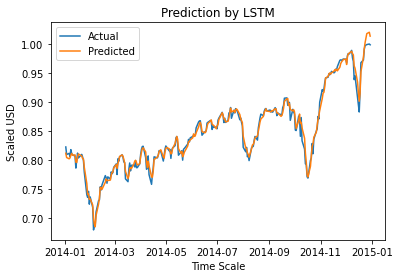

In [16]:
#Predicted vs Actual Value – Scaled
plt.plot(pd.Series(y_test, index=test_index), label='Actual')
plt.plot(pd.Series(y_pred, index=test_index), label='Predicted')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

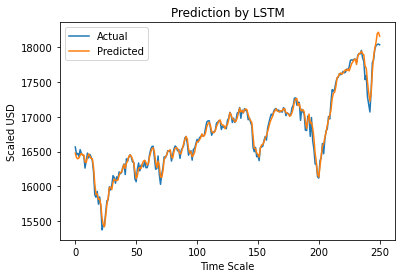

In [17]:
#Predicted vs Actual Value – Reverted back to true value
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = target_scaler.inverse_transform(y_pred.reshape(-1, 1))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_actual, label='Predicted')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

## Performance Evaluation

In [18]:
# Performance metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_test_actual, y_pred_actual)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print('RMSE: '+str(rmse))

MSE: 3883.9728711876774
MAE: 45.21009711155381
RMSE: 62.3215281518969
